# Introdução

A tarefa é estimar as probabilidades de *churn*, *appetency* e *up-selling* em um dataset composto de 230 variáveis na versão **small** e 15000 na versão **large** que discriminam informações de clientes.

A métrica de avaliação é chamada de *AUC* nomeada por ser a área embaixo da curva da [operating characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). E ela deve ser obtida com a comparação da predição dos dados de testes com seus valores reais.

Na época da competição os organizadores disponibilizaram um pré-envio que cálculava o valor da *AUC* para 10% das amostras de testes de modo que os participantes pudessem comparar diversos modelos, porém sem a possibilidade de realizar um ajuste fino resultando no sobreajuste do modelo aos dados de teste.

Como a classificação correta dos dados de testes não está disponível do site da competição, aplicarei o cálculo da *AUC* para uma parcela dos dados originalmente intencionados ao treinamento.

A apresetanção segue o treinamento para a predição de *appetency* para o dataset **small**. As demais análises seguem a mesma lógica,  alterando somente os parâmetros do modelo e os limites onde serão realizados os seccionamentos dos dados. O envio das predições é referente ao treinamento no dataset **large**.

# Importação dos módulos

 Importando os módulos que serão utilizados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

/Users/ruanputka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Configurando o estilo da biblioteca de plotagem *matplotlib* para se igualar ao estilo utilizado pela biblioteca *seaborn*.

In [2]:
plt.style.use('ggplot')

# Pré-processamento dos dados



O pré-processamento será realizado juntamente com uma breve análise exploratória dos dados. O intutivo é conseguir selecionar as variáveis que serão utilizadas para o treinamento e tratá-las de maneira a aumentar o poder de generalização do modelo e diminuir seu tempo de treinamento.

Como não possuímos nenhuma informação sobre o significado das variáveis, se torna difícil especular sobre a importância de cada uma à predição. Desta maneira o filtro grosso baseado em um conhecimento especialista do problema, que geralmente compõe o primeiro passo de um tratamento de dados, acaba sendo ignorado.

 O conhecimento especialista auxilia também a realizar outras análises de maneira rápida e torna o modelo mais interpretrativo. Em um caso onde trabalhei ano passado pretendiamos estimar a temperatura de motores em operação baseados em dados de ensaio e em suas características construtivas. O dataset original possuía o campo *carcaça* composto por códigos alfanuméricos onde os primeiros dígitos indicavam a altura e comprimento da carcaça e os últimos a furação dos pés do motor. Através do conhecimento que possuímos sobre motores elétricos, extraímos do código somente os dígitos correspondentes ao comprimento da carcaça e os transformaram para um valor numérico com significado físico. Originalmente os valores do comprimento eram letras como S, M e L de *small*, *medium* e *large* que juntamente com a informação da altura da carcaça em polegadas podiam ser relacionadas em uma tabela para se obter o comprimento em unidade dimensional. Sem essa percepção, uma solução seria realizar a codificação *One Hot Enconding* no código composto pela altura e pelo comprimento, aumentando drásticamente a [dimensionalidade do espaço de variáveis](https://en.wikipedia.org/wiki/Curse_of_dimensionality) e ignorando a relação natural que o comprimento possuí com a temperatura. 

Sem a possibilidade e usar esse conhecimento privilegiado, iremos adotar uma estratégia focada em elimar:

1. Características com um único valor
2. Características colineares (altamente correlacionadas)
3. Caracterísricas que possuem um percentual alto de valores não preenchidos 
4. Características de baixa significância



O primeiro passo será carregar os dados de treinamento do dataset **small**.

In [3]:
# Load training data
X_train = pd.read_table(
        "orange_small_train.data//orange_small_train.data",
        na_filter=True, nrows=5e3)

y_train = pd.read_table(
        "orange_small_train.data//orange_small_train_appetency.labels",
        nrows=5e3, names=['Label'])

Realizando a binarização da classe para poder ser utilizada nas implementações dos classificadores que testaremos.

In [4]:
y_train[y_train == -1] = 0

Iremos também dividir os dados que possuem valores numéricos dos nominais para análise.

In [5]:
# pd.DataFrame objects holding the numerical and categorical variables
X_train_numerical = X_train.select_dtypes(np.number)
X_train_categorical = X_train.select_dtypes(object)

numerical_columns = X_train.select_dtypes(np.number).columns.tolist()
categorical_columns = X_train.select_dtypes(object).columns.tolist()

print("Número de variáveis numéricas: %d" %len(numerical_columns))
print("Número de variáveis categoricas: %d" %len(categorical_columns))

Número de variáveis numéricas: 192
Número de variáveis categoricas: 38


Inicialmente olharemos para a fração de amostras que se enquadram na categoria positiva.

In [6]:
(y_train == 1).sum()/y_train.shape[0] * 100

Label    1.76
dtype: float64

Conseguimos avaliar que 1,76% da classe possuí *appetency* positivo. Em outras palavras, 88 das 5000 amostras são de clientes dispostos a comprar o produto. Neste caso percebemos que estamos lidando com um dataset desbalanceado.

## Dados numéricos

Começaremos o tratamento com os dados numéricos. O primeiro passo será a contagem das variáveis sendo elas divididas pela quantidade em percentual de valores faltantes.

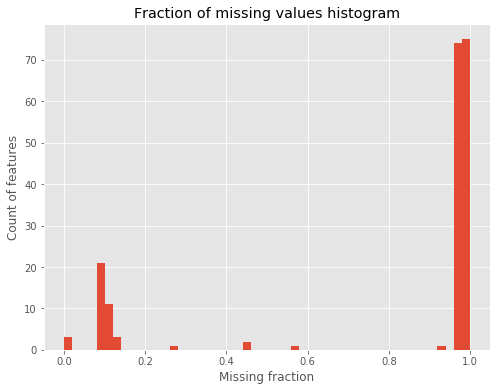

In [7]:
missing_values = X_train_numerical.isnull().sum() / X_train_numerical.shape[0]
plt.figure(figsize=(8, 6))
ax = missing_values.hist(bins=50)
ax.set_title("Fraction of missing values histogram")
ax.set_ylabel("Count of features")
ax.set_xlabel("Missing fraction")
plt.show()

É possível ver dois grandes grupos de variáveis. Um possuí quase todos seus valores faltantes, enquanto o outro possuí menos de 20%. Iremos trabalhar somente com as variáveis do último grupo pela consideração de que os dados faltantes seriam importantes a classificação e preencheremos os valores faltantes com o valor médio da variável.

In [8]:
# Dropping columns with more than max_nan_percentage of missing values
max_nan_percentage = .2
missing_values = missing_values.where(
        missing_values < max_nan_percentage).dropna()
remaining_columns = missing_values.index.tolist()
X_train_numerical = X_train_numerical[remaining_columns]

O número de variáveis numéricas passou de 192 para 38 (redução de 80%):

In [9]:
"Número de variáveis numéricas: %d" %X_train_numerical.shape[1]

'Número de variáveis numéricas: 38'

O próximo passo será eliminar as variáveis redundantes, i.e. que pouco adicionam informações novas, utilizando o coeficiente de correlação de Pearson $r$. De forma breve, o coeficiente explica o comportamente colinear entre duas variáveis. Ele pode assumir qualquer valor real entre -1 e 1 e quanto maior seu valor absoluto mais forte é a correlação. O sinal indica o sentido da correlação (positivo ou negativo). A imagem abaixo ilustra como os dados podem estar distribuídos em alguns valores de $r$, ajudando a criar uma intuição sobre a escala.

<img src="images/correlation-example.png"/>

Para vários propósitos em análises estatísticas, valores absolutos de $r$ acima de 0,7 indicam uma forte correlação. Com isso em mente, vamos explorar através de um mapa de calor a correlação entre todas as variáveis umas as outras. 

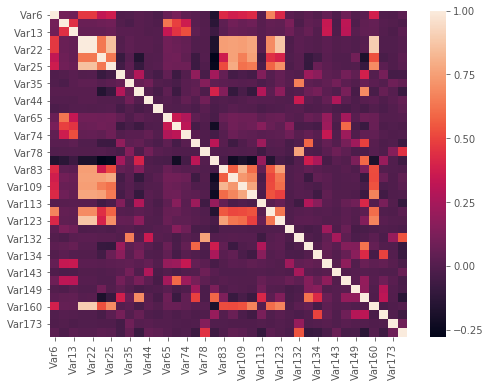

In [10]:
# Plotting a heatmap to determine if any variables are correlated
plt.figure(figsize=(8, 6))
sns.heatmap(data=X_train_numerical.corr())
plt.show()

Nota-se que não existem casais de variáveis com uma forte correlação negativa, porém uma pequena parcela aparenta se correlacionar fortemente em um sentido positivo. 
Com uma pequena manipulações dos dados é possível visualizar todos os casais que possuem uma correlação forte ($r$ maior ou igual a 0,7).

In [11]:
corr_threshold = 0.7
c = X_train_numerical.corr().abs()
s = c.unstack()
s.drop_duplicates(inplace=True)
s[(s >= .7) & (s < 1)]

Var21   Var22     1.000000
        Var25     0.859131
        Var83     0.749562
        Var85     0.756807
        Var109    0.749311
        Var112    0.771732
        Var123    0.871989
        Var160    0.896317
Var22   Var25     0.859385
        Var83     0.749668
        Var85     0.757232
        Var109    0.749352
        Var112    0.772137
        Var123    0.872010
        Var160    0.896456
Var24   Var85     0.756538
        Var112    0.755595
Var25   Var85     0.787264
        Var123    0.706469
Var78   Var132    0.760616
Var83   Var109    0.822855
        Var123    0.758623
Var85   Var109    0.726156
Var109  Var112    0.774004
dtype: float64

Através das relações acima, seleciona-se somente uma variável de cada par para continuar entre os dados de treinamento.

In [12]:
# Dropping columns that are highly correlated i.e. that only add redundant info
to_drop_columns = ["Var22", "Var25", "Var83", "Var85", "Var109", "Var112",
                   "Var123", "Var160", "Var132"]
X_train_numerical.drop(to_drop_columns, axis=1, inplace=True)

É interessante plotar a distrubuição de cada variável separando-as por classe.

/Users/ruanputka/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


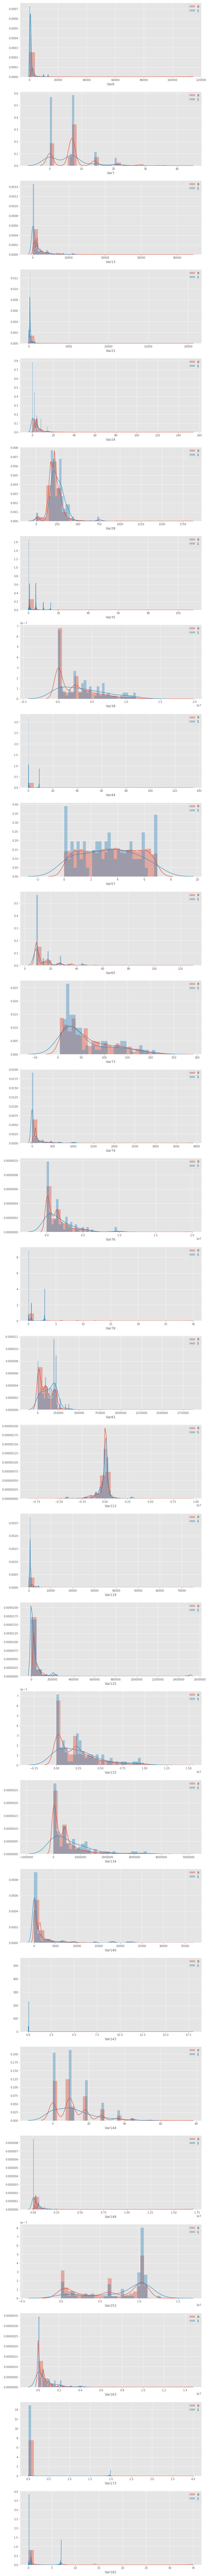

In [13]:
ncols = X_train_numerical.shape[1]
plt.figure(figsize=(12, 6*ncols))
X_train_numerical.fillna(X_train_numerical.mean(), inplace=True)
for position, column_name in enumerate(X_train_numerical.columns):
    ax = plt.subplot(ncols, 1, position+1)
    sns.distplot(X_train_numerical[(y_train == 0).values][column_name],
                                   bins=30, label="0")
    sns.distplot(X_train_numerical[(y_train == 1).values][column_name],
                                   bins=30, label="1")
    ax.legend()
plt.show()

Uma informação importante que retiramos destes gráficos é que um grande número de variáveis possuem valores discrepantes (*outliers*). Desta maneira, realizaremos uma normalização das variavéis que é sensível a presença de *outliers* juntamente com modelos especialmente robustos para este tipo de dado.

A normalização que usaremos consiste em transformar os dados de cada variável para uma distruição equivalente com média zero e variância unitária. A motivação por trás do processo de normalização vem do fato de que os modelos de classifição calculam a distância euclidiana entre os pontos e se alguma variável possuir valores comparativamente altos, sua contribuição a distância final será proporicionalmente maior. Após a normalização, as variáveis tendem a contribuir igualmente a distância total entre os pontos do modelo.

In [14]:
# Scaling numerical features
scaler = StandardScaler()
X_train_numerical[X_train_numerical.columns] = (
        scaler.fit_transform(X_train_numerical)
        )

# Dados categóricos

Com os dados numéricos prontos para o treinamento, passamos a nossa atenção para os categóricos.Iremos plotar a distribuição da porcentagem dos valores faltantes por variável como feito com os dados numéricos.

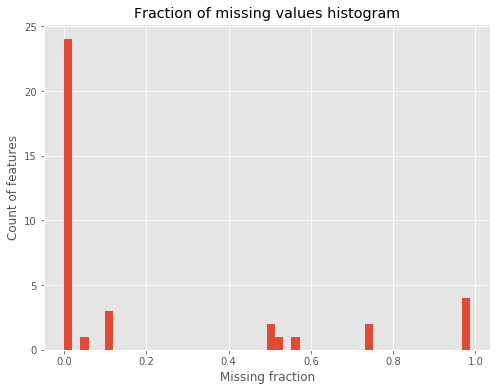

In [15]:
# Plotting the histogram of categorical missing values
missing_values = (
        X_train_categorical.isnull().sum() /
        X_train_categorical.shape[0]
        )
plt.figure(figsize=(8, 6))
ax = missing_values.hist(bins=50)
ax.set_title("Fraction of missing values histogram")
ax.set_ylabel("Count of features")
ax.set_xlabel("Missing fraction")
plt.show()


Como a maioria das variáveis possuem menos que 20% dos valores faltantes usaremos este limite como filtro.

In [16]:
# Dropping columns with more than max_nan_percentage of missing values
max_nan_percentage = 0.2
missing_values = missing_values.where(
        missing_values < max_nan_percentage).dropna()
remaining_columns = missing_values.index.tolist()
X_train_categorical = X_train_categorical[remaining_columns]

O passo seguinte será codificar as variáveis para uso nos modelos numéricos. Utilizaremos uma codificação a quente (*one hot encoding*) que consiste em transformar uma variável em $n$ outras variáveis auxiliares binárias, onde $n$ é o número de valores únicos que a variável original pode assumir. Cada variável nova corresponde a um valor nominal. A figura a seguir exemplifica a lógica:

<img src="images/ohe-example.png"/>

Porém antes de realizar a codificação é interessante olhar para a quantidade de variáveis que serão criadas. Podemos considerar filtrar as variáveis que necessitam de muitos bits para codificação ($n$ alto):

In [17]:
# Print number of bits needed to one hot encode each column
num_bits = X_train_categorical.nunique().sort_values()
for max_num_bits in num_bits.unique():
    num_categorical_columns = num_bits[(num_bits <= max_num_bits)].sum()
    print("Maximum number of bits on OHE: %d \n"
          "Number of categorical columns: %d \n"
          % (max_num_bits, num_categorical_columns))
    

Maximum number of bits on OHE: 2 
Number of categorical columns: 8 

Maximum number of bits on OHE: 3 
Number of categorical columns: 11 

Maximum number of bits on OHE: 4 
Number of categorical columns: 19 

Maximum number of bits on OHE: 6 
Number of categorical columns: 25 

Maximum number of bits on OHE: 7 
Number of categorical columns: 39 

Maximum number of bits on OHE: 11 
Number of categorical columns: 50 

Maximum number of bits on OHE: 13 
Number of categorical columns: 63 

Maximum number of bits on OHE: 18 
Number of categorical columns: 81 

Maximum number of bits on OHE: 20 
Number of categorical columns: 101 

Maximum number of bits on OHE: 23 
Number of categorical columns: 124 

Maximum number of bits on OHE: 25 
Number of categorical columns: 149 

Maximum number of bits on OHE: 36 
Number of categorical columns: 185 

Maximum number of bits on OHE: 58 
Number of categorical columns: 243 

Maximum number of bits on OHE: 100 
Number of categorical columns: 343 

Maxim

Escolho eliminar dos dados categóricos as colunas que necessitariam mais de 7 bits para codificação de modo que o número total de variáveis auxiliares criadas após a transformação seja igual a 39. Como possuímos 32 variáveis numéricas, esperamos que essa transformação não acrescente uma predileção a nenhum tipo de dado.

In [18]:
# Drop columns that would require 8 bits or more to one hot encode
remaining_columns = num_bits.where(num_bits <= 7).dropna().index.tolist()
X_train_categorical = X_train_categorical[remaining_columns]

# Perform OHE on the categorical features
X_train_categorical = pd.get_dummies(X_train_categorical)

# Treinamento

O treinamento será realizado usando um classificador adaptativo chamado [*AdaBoost*](https://en.wikipedia.org/wiki/AdaBoost) que combina vários classificadores fracos - que neste caso serão árvores de decisões de profundidade reduzida - para formar um classificador forte. Essa técnica chamada [*boosting*](https://codesachin.wordpress.com/tag/adaboost/) produz resultados que são especialmente robustos a valores ruidosos e faltantes, além de gerar modelos com uma tendência baixa de se sobreajustar aos dados de treinamento. Em suma, dado as informações que temos sobre o problema, o *AdaBoost* aparenta ser a melhor opção de algoritmo que podemos testar de maneira eficiente com as restrições computacionais de um notebook.

In [ ]:
# Construct the features and labels matrix for trainning
X = np.concatenate((X_train_numerical.values,
                          X_train_categorical.values), axis=1)
y = y_train.values.reshape(1, -1)[0]

Os dados serão dividos em uma parcela com proporções iguais de categorias positivas. Uma parcela de testes com 33% dos valores totais e outra de treinamento com os restantes 67% são criadas.

In [ ]:
# Splits the training data for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, stratify=y)

O modelo então é treinado utilizando 500 árvores de decisão de profundidade 10 como os classificadores fracos. 

In [ ]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),
                         algorithm="SAMME",
                         n_estimators=500)

bdt.fit(X_train, y_train)

# Resultados

Finalmente o modelo é usado para prever a classe dos dados. O método *predict_proba* retorna a probabilidade da amostra pertencer a classe positiva.

In [ ]:
# probability estimates of the positive class
y_score = bdt.predict_proba(X_test)[:, 1]

E por fim é computado o valor da métrica *AUC*.

In [ ]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot of a ROC curve for appentency class
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Appetency')
plt.legend(loc="lower right")
plt.show()

Os parâmetros do número de estimadores e profundidade das árvores, além dos limiares para os filtros de valores faltantes e número máximo de variáveis faltantes foram ajustados rodando iterativamente os passos descritos anteriormente para ajustar o modelo de modo a aumentar o valor da *AUC*. Em todo o caso, as primeiras considerações feitas se mostraram muito próximas das que resultam na maior área encontrada e não foi testada nenhuma combinação que resulta em um valor extremo.

As figuras a seguir mostram as curvas para a classificação dos dados de *churn* e *upselling*.
<img src="images/roc-churn.png"/>
<img src="images/roc-upselling.png"/>